# **Model Forecast - Comparison and Improvement**

In [1]:
#Necessary Pip Installs 
!pip install pmdarima
!pip install prophet
!pip install kats
# !pip install pydlm

     |████████████████████████████████| 1.4 MB 14.5 MB/s 
     |████████████████████████████████| 9.8 MB 67.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 65 kB 4.6 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638357 sha256=ae35069254b528289fea194c3e25ce6cba123e16badbb3e1ddc7772c89ae8cb4
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [65]:
#Imports
import pandas as pd
import numpy as np
import math
import itertools
%matplotlib inline

# Load specific forecasting tools
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm
from matplotlib import pyplot as plt
#ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima # for determining ARIMA orders  
from statsmodels.tsa.arima.model import ARIMA
#Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
#KATS
from kats.consts import TimeSeriesData
from kats.detectors.outlier import OutlierDetector
#Bayesian
# from pydlm import dlm, trend, seasonality
#Metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [26]:
#Import the Dataset
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')
df.rename(columns={'SalesVolume':'Values'},inplace=True)

In [66]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/tfl-journeys-type.xlsx')
df = df.dropna()

In [67]:
metrics_df = pd.DataFrame(columns=['TYPE','ORDER','MAPE','MSE','RMSE','MAE'])

In [68]:
hyper_df = pd.DataFrame(columns=['TYPE','ORDER','MAPE','MSE','RMSE','MAE'])

In [69]:
df.tail()

,Date,Values
135,2021-07-01,98.5
136,2021-08-01,115.2
137,2021-09-01,129.8
138,2021-10-01,125.0
139,2021-11-01,131.0


In [46]:
#Remove Outliers
def remove_outliers(df):
  kats_df = df.rename(columns={'Date':'time'})
  ts = TimeSeriesData(kats_df)
  outlier_detector = OutlierDetector(ts, "additive",iqr_mult=2)
  outlier_detector.detector()
  ts_day_outliers_interpolated = outlier_detector.remover(interpolate=True)
  # df_final.interpolate(method="linear", limit_direction="both", inplace=True)
  processed_df = ts_day_outliers_interpolated.to_dataframe()
  processed_df.rename(columns={'time':'Date','y_0':'Values'},inplace=True)
  plot_outliers(outlier_detector,ts,processed_df)
  return processed_df

In [47]:
#Print and Plot outliers
def plot_outliers(outlier_detector,ts,processed_df):
  outlier_detector.detector()
  outliers = outlier_detector.outliers
  print(outliers[0])
  ax = ts.to_dataframe().plot(x="time", y="Values")
  processed_df.plot(x="Date", y="Values", ax=ax)
  plt.legend(labels=["original ts", "ts with removed outliers"])
  plt.show()

[Timestamp('2002-05-01 00:00:00'), Timestamp('2016-03-01 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2021-02-01 00:00:00'), Timestamp('2021-03-01 00:00:00')]


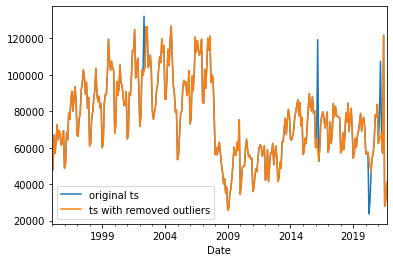

In [29]:
df = remove_outliers(df)

In [33]:
# Exclude pre changepoints data  - Sales Volume
df = df[df['Date']>='2009-01-01']
df = df.reset_index(drop=True)

In [41]:
df.head()

,Date,Values
0,2009-01-01,25782.0
1,2009-02-01,26660.0
2,2009-03-01,34857.0
3,2009-04-01,37585.0
4,2009-05-01,43500.0


# **ARIMA**

In [70]:
def arima_check(arima_df):
  diff_order = stationarity_check(arima_df)
  if diff_order > 0:
    print('Requires differencing of order: ',diff_order )
  auto_arima_summary = auto_arima(arima_df['Values'], seasonal=False).summary()
  return auto_arima_summary,arima_df

In [71]:
def stationarity_check(st_check_df):
  order = 0
  input_df = st_check_df.copy()
  while True:
    check_stationarity = adf_test(input_df['Values'])
    if not check_stationarity:
      input_df['Values'] = diff(input_df['Values'],k_diff=1)
      input_df = input_df.iloc[1:,:]
      order +=1
      continue
    else:
      break
  return order

In [72]:
#Preprocessing before feeding into the ARIMA models
def arima_preprocess(input_df):
  """
  Pass in the input df returns a dataframe after processing the date field
  """
  input_df['Date'] = pd.DatetimeIndex(input_df['Date'])
  input_df = input_df.groupby('Date').sum()
  #Settting a Monthly frequency and also to the first day of the month
  input_df = input_df.asfreq('MS')
  # input_df = input_df.asfreq('W-Sat')
  return input_df

In [73]:
#Stationarity Check
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        return True
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        return False

In [74]:
def arima_train(arima_df,model_type,order_tpl,season_tpl,freq):
  # Setting the last 7 months for testing
  model = None
  index = len(arima_df) - 11
  train = arima_df.iloc[:index]
  test = arima_df.iloc[index:]
  if model_type == 'SARIMAX':
    model=sm.tsa.statespace.SARIMAX(arima_df['Values'],order=order_tpl)
    model = sm.tsa.statespace.SARIMAX(arima_df['Values'],  # this is your time series you will input
                                                order=order_tpl,
                                                seasonal_order=season_tpl,
                                                # enforce_stationarity=False,
                                                # enforce_invertibility=False,
                                                freq=freq)
  elif model_type == 'ARIMA':
    model=ARIMA(arima_df['Values'],order=order_tpl)
  results=model.fit()
  start=len(train)
  end=len(train)+len(test)-1
  predictions_SARIMAX = results.predict(start=start, end=end).rename('Predictions')
  test['Predictions'] = predictions_SARIMAX
  return test

# **Common Utils**

In [75]:
#Metrics Evaluation
def metrics(metrics_df,input_df,model_type,order):
  metrics_df = metrics_df.append({'TYPE':model_type,
                                  'ORDER':order,
                                  'MAPE':mean_absolute_percentage_error(input_df['Values'], input_df['Predictions']),
                                  'MSE':mean_squared_error(input_df['Values'], input_df['Predictions']),
                                  'RMSE':rmse(input_df['Values'], input_df['Predictions']),
                                  'MAE':mean_absolute_error(input_df['Values'], input_df['Predictions'])
                                  }
                                 ,ignore_index=True)
  return metrics_df

In [76]:
def pred_plot(plot_df):
  title = 'Forecast'
  ylabel='Values'
  xlabel = 'Date'
  ax = plot_df['Values'].plot(legend=True,figsize=(12,6),title=title)
  plot_df['Predictions'].plot(legend=True)
  ax.autoscale(axis='x',tight=True)
  ax.set(xlabel=xlabel, ylabel=ylabel);

In [77]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(input_df, model_type,hyper_df):
    #Input Hyperparams
    d_values = range(2,4)
    p_values = q_values = range(0, 5)
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    arima_pred_df = arima_train(input_df, model_type,order,None,None)
                    hyper_df = metrics(hyper_df, arima_pred_df, model_type,order)
                except:
                    continue
    hyper_df = hyper_df.sort_values(by=['MAPE'])
    return hyper_df

In [78]:
def evaluate_models_SARIMAX(arima_df,model_type,hyper_df):
    d = range(0, 3)
    p =  q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    freq='MS'
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
              arima_pred_df = arima_train(arima_df,model_type,comb,combs,freq)
              hyper_df = metrics(hyper_df, arima_pred_df, model_type,comb + combs)
            except:
              continue
    hyper_df = hyper_df.sort_values(by=['MAPE'])
    return hyper_df

### **ARIMA Model Execution**

In [79]:
arima_df = arima_preprocess(df)

In [58]:
arima_df.head()

,Values
Date,
2010-04-01,185.4
2010-05-01,175.9
2010-06-01,183.4
2010-07-01,160.4
2010-08-01,175.8


In [59]:
auto_arima(arima_df['Values'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  140
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -602.126
Date:                Fri, 28 Jan 2022   AIC                           1210.253
Time:                        15:13:14   BIC                           1219.056
Sample:                             0   HQIC                          1213.830
                                - 140                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3252      0.223      1.461      0.144      -0.111       0.761
ma.L1         -0.7189      0.187     -3.851      0.000      -1.085      -0.353
sigma2       338.1922     23.626     14.315      0.000     291.887     384.497
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               416.68
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -1.90
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
auto_arima_summary,arima_df = arima_check(arima_df)

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.214262
p-value                   0.201110
# lags used              13.000000
# observations          126.000000
critical value (1%)      -3.483346
critical value (5%)      -2.884766
critical value (10%)     -2.579156
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic       -2.535161
p-value                   0.107152
# lags used              12.000000
# observations          126.000000
critical value (1%)      -3.483346
critical value (5%)      -2.884766
critical value (10%)     -2.579156
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -5.849342e+00
p-value                 3.620128e-07
# lags used             1.100000e+01
# observations          1.260000e+02
critical value (1%)    -3.483

In [23]:
hyper_model = 'SARIMAX'
model_dict = {'SARIMAX':(9,1,2), 'ARIMA':(9,1,2)}

In [ ]:
# auto_arima_summary,arima_df = arima_check(arima_df)
# print(auto_arima_summary)
if hyper_model == 'ARIMA':
  #For UK hosue price
  order = (4, 1, 4)
  # For UK TFL - (4, 2, 3)
  arima_pred_df = arima_train(arima_df,hyper_model,order,None,None)
  metrics_df = metrics(metrics_df,arima_pred_df,hyper_model,order)
elif hyper_model == 'SARIMAX':
  # order = (4,1,2)
  # seasonal_order = (4,1,2,12)
  # 3, 1, 0 - Suggested for after changepoints
  # order = (3,1,0)
  # seasonal_order = (3,1,0,12)

  #Jupyter grid search params for UK housing
  (4, 1, 2, 3, 1, 3, 12)
  #Jupyter grid search params for UK TFL
  (4, 2, 4, 4, 2, 3, 12)	
  order = (4, 1, 2)
  seasonal_order = (3, 1, 3,12)
  arima_pred_df = arima_train(arima_df,hyper_model,order,seasonal_order,'MS')
  metrics_df = metrics(metrics_df,arima_pred_df,hyper_model,order)
elif hyper_model == 'ALL':
  for key in model_dict.keys():
    arima_pred_df = arima_train(arima_df,key,model_dict[key])
    metrics_df = metrics(metrics_df,arima_pred_df,key,model_dict[key])

In [61]:
metrics_df

,TYPE,ORDER,MAPE,MSE,RMSE,MAE


In [80]:
hyper_df = evaluate_models(arima_df,'ARIMA',hyper_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [81]:
print(hyper_df.iloc[0])

TYPE         ARIMA
ORDER    (0, 2, 1)
MAPE       0.11483
MSE        170.115
RMSE       13.0428
MAE        10.8404
Name: 1, dtype: object


In [82]:
hyper_df.sort_values(by=['MAE'])

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
43,ARIMA,"(4, 2, 3)",0.116515,182.544859,13.510916,10.559043
1,ARIMA,"(0, 2, 1)",0.114830,170.115344,13.042827,10.840447
28,ARIMA,"(2, 3, 3)",0.131552,184.784022,13.593529,11.134866
23,ARIMA,"(2, 2, 3)",0.134794,175.227759,13.237362,11.562497
33,ARIMA,"(3, 2, 3)",0.135318,177.457644,13.321323,11.617891
38,ARIMA,"(3, 3, 3)",0.133129,232.452251,15.246385,11.747352
39,ARIMA,"(3, 3, 4)",0.140487,200.193579,14.148978,12.115821
7,ARIMA,"(0, 3, 2)",0.127498,221.114445,14.869917,12.170531
11,ARIMA,"(1, 2, 1)",0.140717,240.194144,15.498198,12.717260
4,ARIMA,"(0, 2, 4)",0.134569,240.769335,15.516744,12.863358


In [83]:
hyper_df.sort_values(by=['MAE'])

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
43,ARIMA,"(4, 2, 3)",0.116515,182.544859,13.510916,10.559043
1,ARIMA,"(0, 2, 1)",0.114830,170.115344,13.042827,10.840447
28,ARIMA,"(2, 3, 3)",0.131552,184.784022,13.593529,11.134866
23,ARIMA,"(2, 2, 3)",0.134794,175.227759,13.237362,11.562497
33,ARIMA,"(3, 2, 3)",0.135318,177.457644,13.321323,11.617891
38,ARIMA,"(3, 3, 3)",0.133129,232.452251,15.246385,11.747352
39,ARIMA,"(3, 3, 4)",0.140487,200.193579,14.148978,12.115821
7,ARIMA,"(0, 3, 2)",0.127498,221.114445,14.869917,12.170531
11,ARIMA,"(1, 2, 1)",0.140717,240.194144,15.498198,12.717260
4,ARIMA,"(0, 2, 4)",0.134569,240.769335,15.516744,12.863358


In [ ]:
hyper_df = evaluate_models_SARIMAX(arima_df,'SARIMAX',hyper_df)
print(hyper_df.iloc[0])

In [ ]:
hyper_df.sort_values(by=['MAPE'])

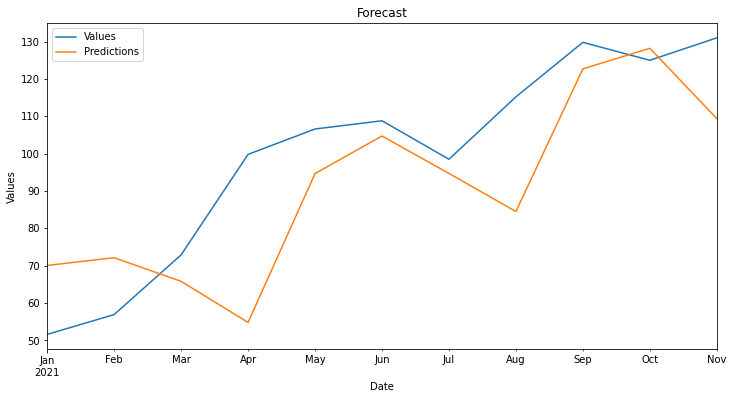

In [29]:
pred_plot(arima_pred_df)

In [61]:
metrics_df

,TYPE,ORDER,MAPE,MSE,RMSE,MAE


# **Prophet**

In [40]:
prophet_pred_df, metrics_df = prophet_base_model(df,metrics_df)

In [31]:
def prophet_base_model(input_df,metrics_df):
  prophet_forecast = prophet_model(input_df)
  index = len(prophet_forecast) - 11
  prophet_forecast = prophet_forecast[index:].rename(columns={'ds':'Date','yhat':'Predictions'})
  prophet_pred_df = prophet_forecast[['Date','Predictions']]
  prophet_metrics_df = df[index:]
  prophet_metrics_df = prophet_metrics_df.merge(prophet_pred_df, on='Date', how='left')
  metrics_df = metrics(metrics_df,prophet_metrics_df,'Prophet',None)
  return prophet_metrics_df,metrics_df

In [44]:
def prophet_model(input_df):
  index = len(input_df) - 11
  train_df = input_df[:index].rename(columns={'Date':'ds', 'Values':'y'})
  default_params = {  
    'changepoint_prior_scale': 0.05,
    'changepoint_range' : 0.8,
    'seasonality_prior_scale': 10.0,
  }

  #UK House
  # best_params = {
  #     'changepoint_prior_scale': 0.1,
  #   'changepoint_range' : 0.8,
  #   'seasonality_prior_scale': 0.01,
  # }

  #TFL
  best_params = {
      'changepoint_prior_scale': 0.01,
    'changepoint_range' : 0.85,
    'seasonality_prior_scale': 0.01,
  }
  #UK House
  # changepoints_params = {
  #     'changepoint_prior_scale': 0.1,
  #     'changepoint_range' : 0.8,
  #     'seasonality_prior_scale': 0.01,
  #     'changepoints' : ['2002-12-01','2007-11-01','2007-12-01','2020-03-01'],
  # }

  #TFL
  changepoints_params = {
      'changepoint_prior_scale': 0.01,
      'changepoint_range' : 0.8,
      'seasonality_prior_scale': 0.01,
      'changepoints' : ['2020-02-01','2020-03-01','2020-04-01','2020-05-01'],
  }


  # changepoints_arr = ['2002-12-01','2007-11-01','2007-12-01','2020-03-01']
  model , forecast = model_train_predict(train_df,changepoints_params)
  return forecast

In [33]:
#Train and fit the model
def model_train_predict(input_df,params):
  m = None
  m = Prophet( seasonality_mode='additive', 
            yearly_seasonality= True,
            daily_seasonality = False,
            weekly_seasonality = False,
            **params)
  m.fit(input_df)
  # Forcasting into the future
  future = m.make_future_dataframe(periods=11,freq='MS')
  # future = m.make_future_dataframe(periods=11,freq='W-Sat')
  forecast = m.predict(future)
  return m, forecast

In [41]:
metrics_df

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
0,ARIMA,"(4, 1, 4)",0.170314,390.070986,19.750215,15.291721
1,Prophet,None,0.482487,1962.056431,44.295106,33.902354
2,Prophet,None,0.561291,2486.359990,49.863413,41.162928


In [42]:
test_df = arima_preprocess(prophet_pred_df)

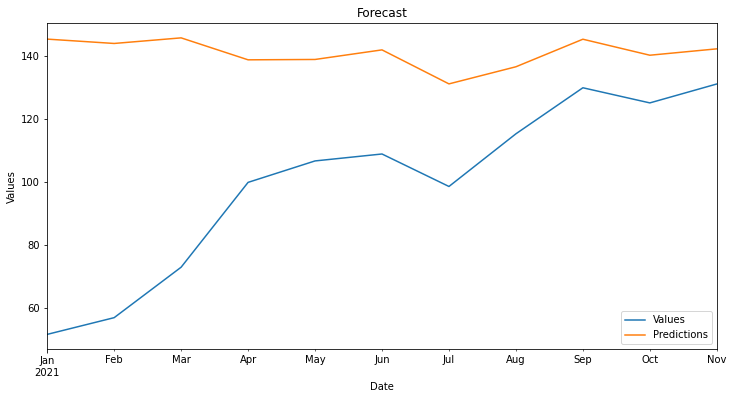

In [43]:
pred_plot(test_df)

In [26]:
#Prophet -  Adding changepoints - DONE
#Overall - Remove anomalies (Mean vs Median absolutte deviatio - if possible) - DONE
#Bayesian Forecast
#OVerall - predict after the changepoint - done
#OVerall - experiment for differernt datasets
# Overall - standardise before training
#ARIMA - hyper parameter tuning - Done 
#ARIMA - other flavours of ARIMA - SARIMA is left 


In [27]:
metrics_df

,TYPE,ORDER,MAPE,MSE,RMSE,MAE
0,Prophet,None,0.850834,1.348879,1.161412,1.153157


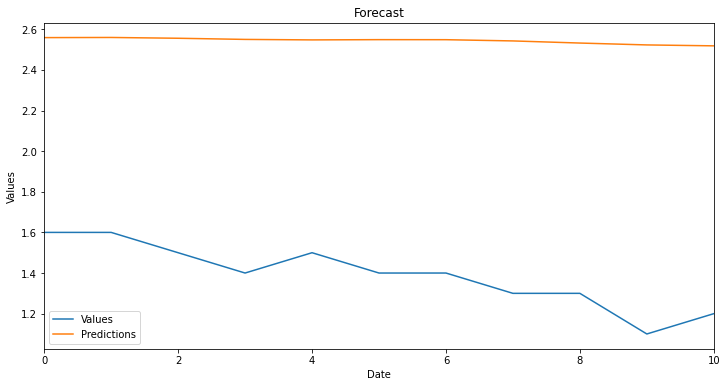

In [28]:
pred_plot(prophet_pred_df)